In [2]:
#from graphviz import Digraph
from torch.autograd import Variable

import numpy as np
import torch
import matplotlib.pyplot as plt

from utils import ALL_LETTERS, N_LETTERS
from utils import load_data, letter_to_tensor, line_to_tensor, random_training_example

import os
os.environ["PATH"] += os.pathsep + 'C:/Users/Erick/miniconda3/envs/pytorch_examples/Library/bin/graphviz/'

### This function is used to visualize pytorch computation graph

In [2]:
def make_dot(var, params=None):
    if params is not None:
        assert isinstance(params.values()[0], Variable)
        param_map = {id(v): k for k, v in params.items()}

    node_attr = dict(style="filled", shape="box", align="left", fontsize="12", ranksep="0.1", height="0.2")
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()

    def size_to_str(size):
        return "(" + (", ").join(["%d" % v for v in size]) + ")"

    def add_nodes(var):
        if var not in seen:
            if torch.is_tensor(var):
                dot.node(str(id(var)), size_to_str(var.size()), fillcolor="orange")
                dot.edge(str(id(var.grad_fn)), str(id(var)))
                var = var.grad_fn
            if hasattr(var, "variable"):
                u = var.variable
                name = param_map[id(u)] if params is not None else ""
                node_name = "%s\n %s" % (name, size_to_str(u.size()))
                dot.node(str(id(var)), node_name, fillcolor="lightblue")
            else:
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, "next_functions"):
                for u in var.next_functions:
                    if u[0] is not None:
                        dot.edge(str(id(u[0])), str(id(var)))
                        add_nodes(u[0])
            if hasattr(var, "saved_tensors"):
                for t in var.saved_tensors:
                    dot.edge(str(id(t)), str(id(var)))
                    add_nodes(t)

    add_nodes(var)
    return dot

In [39]:
class LSTM(torch.nn.Module):

    def __init__(self, input_size, output_size):
        super(LSTM, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = output_size
        self.output_size = output_size
        
        self.forget = torch.nn.Linear(input_size + self.hidden_size, output_size)
        self.keep1 = torch.nn.Linear(input_size + self.hidden_size, output_size)
        self.keep2 = torch.nn.Linear(input_size + self.hidden_size, output_size)
        self.output = torch.nn.Linear(input_size + self.hidden_size, output_size)
        
        self.softmax = torch.nn.LogSoftmax(dim=1)
        
    def forward(self, input_tensor, hidden_tensor, cell_tensor):
        
        combined_input_hidden = torch.cat((input_tensor, hidden_tensor), 1)
        
        ft = torch.sigmoid(self.forget(combined_input_hidden))
        it = torch.sigmoid(self.keep1(combined_input_hidden))
        cell_candidate = torch.tanh(self.keep2(combined_input_hidden))
        
        new_cell = (ft * cell_tensor) + (it * cell_candidate)
        
        ot = torch.sigmoid(self.output(combined_input_hidden))
        
        new_hidden = ot * torch.tanh(new_cell)
        
        output = self.softmax(new_hidden)
        
        return output, new_hidden, new_cell
    
    def init_hidden(self):
        return torch.zeros(1, self.output_size)

In [35]:
category_lines, all_categories = load_data()

def category_from_output(output):
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]

In [47]:
n_categories = len(all_categories)

#Hyperparameter, number of outputs in hidden layer 
n_hidden = n_categories

lstm = LSTM(N_LETTERS, n_categories)


criterion = torch.nn.NLLLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(lstm.parameters(), lr = learning_rate)

In [48]:
def train(line_tensor, category_tensor):
    hidden = lstm.init_hidden()
    cell = lstm.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden, cell = lstm(line_tensor[i], hidden, cell)
        
    loss = criterion(output, category_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

4999 0.5 2.8762 O'Dowd / Greek WRONG (Irish)
9999 1.0 2.8523 Antar / German WRONG (Arabic)
14999 1.5 2.7429 Kijek / Czech WRONG (Polish)
19999 2.0 2.8280 Cruz / Spanish WRONG (Portuguese)
24999 2.5 2.3325 Vuong / Chinese WRONG (Vietnamese)
29999 3.0 2.3875 Marquering / English WRONG (Dutch)
34999 3.5 2.1949 Okanao / Japanese CORRECT
39999 4.0 3.2947 Niemec / German WRONG (Polish)
44999 4.5 3.2039 Moriguchi / Italian WRONG (Japanese)
49999 5.0 2.2406 Hajkova / Japanese WRONG (Czech)
54999 5.5 2.2485 Koziol / Japanese WRONG (Polish)
59999 6.0 2.5126 Plamondon / Scottish WRONG (French)
64999 6.5 2.5789 Fitzpatrick / Czech WRONG (English)
69999 7.0 2.2971 Blanchet / English WRONG (French)
74999 7.5 2.2385 Hirase / Japanese CORRECT
79999 8.0 2.1723 Jelyabujsky / Polish WRONG (Russian)
84999 8.5 1.4179 Moshnikov / Russian CORRECT
89999 9.0 1.8403 Shim / Vietnamese WRONG (Korean)
94999 9.5 1.4713 Abjaliloff / Russian CORRECT
99999 10.0 2.2242 Ma / Vietnamese WRONG (Korean)
104999 10.5 2.1921 

864999 86.5 2.6358 Koning / Dutch CORRECT
869999 87.0 1.4537 Kvasnicka / Czech CORRECT
874999 87.5 1.5915 Sarkis / Arabic CORRECT
879999 88.0 1.9253 Wyrick / Czech WRONG (Polish)
884999 88.5 1.5807 Rademaker / Dutch CORRECT
889999 89.0 1.4919 Than / Vietnamese CORRECT
894999 89.5 2.3976 Altham / English CORRECT
899999 90.0 1.4758 Abboud / Arabic CORRECT
904999 90.5 1.4448 Bach / Vietnamese CORRECT
909999 91.0 1.6717 Ramirez / Spanish CORRECT
914999 91.5 1.6410 Kloeten / German WRONG (Dutch)
919999 92.0 1.6791 Tieu / Vietnamese CORRECT
924999 92.5 1.8531 Holan / Czech CORRECT
929999 93.0 1.8671 De sauveterre / Dutch WRONG (French)
934999 93.5 2.0651 Gerald / French WRONG (Irish)
939999 94.0 1.6345 Marshall / Scottish CORRECT
944999 94.5 1.6373 Ding / Vietnamese WRONG (Chinese)
949999 95.0 1.4127 Masuzoe / Japanese CORRECT
954999 95.5 1.3212 Newby / English CORRECT
959999 96.0 2.9687 Kunkel / Czech WRONG (German)
964999 96.5 1.8641 Meeuwe / French WRONG (Dutch)
969999 97.0 1.9475 Maria /

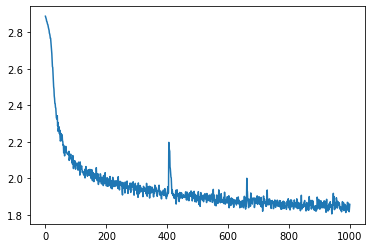

In [49]:
current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 1000000

for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)
    
    output, loss = train(line_tensor, category_tensor)
    current_loss += loss
    
    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0
        
    if (i+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == category else f"WRONG ({category})"
        print(f"{i} {i/n_iters*100:.1f} {loss:.4f} {line} / {guess} {correct}")
        
plt.figure()
plt.plot(all_losses)
plt.show()

In [51]:
def predict(input_line):
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)
        
        hidden = lstm.init_hidden()
        cell = lstm.init_hidden()
        for i in range(line_tensor.size()[0]):
            output, hidden, cell = lstm(line_tensor[i], hidden, cell)
            
        gess = category_from_output(output)
        return gess

In [54]:
predict('Srinivasa')

'Spanish'

### Notes

* https://colah.github.io/posts/2015-08-Understanding-LSTMs/